<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание--данных" data-toc-modified-id="Описание--данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание  данных</a></span></li><li><span><a href="#Обзор-и-предобработка-данных" data-toc-modified-id="Обзор-и-предобработка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обзор и предобработка данных</a></span><ul class="toc-item"><li><span><a href="#Вывод-по-обзору-и-предобработке-данных" data-toc-modified-id="Вывод-по-обзору-и-предобработке-данных-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Вывод по обзору и предобработке данных</a></span></li></ul></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ данных</a></span><ul class="toc-item"><li><span><a href="#Вывод-по-анализу-данных." data-toc-modified-id="Вывод-по-анализу-данных.-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Вывод по анализу данных.</a></span></li></ul></li><li><span><a href="#Построение-моделей" data-toc-modified-id="Построение-моделей-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Построение моделей</a></span><ul class="toc-item"><li><span><a href="#Добавление-признаков." data-toc-modified-id="Добавление-признаков.-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Добавление признаков.</a></span></li><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#LGBMRegressor" data-toc-modified-id="LGBMRegressor-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>LGBMRegressor</a></span></li></ul></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

# Прогнозирование заказов такси

## Описание  данных

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час.

**Цель проекта:**

Построить модель для такого предсказания со значением метрики RMSE на тестовой выборке не больше 48.

**План работ:**

- 1. Подготовка данных
    - Откроем данные и изучим их.
    - Выполним их ресемплирование по одному часу.
    
- 2. Проанализируем данные.
    
- 3. Обучим разные модели с различными гиперпараметрами. Сделаем тестовую выборку размером 10% от исходных данных.
    
- 4. Проверим данные на тестовой выборке и сделаем общий вывод.

## Обзор и предобработка данных

In [134]:
# ячейка для загрузки библиотек, служебных команд и функций
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import warnings

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from IPython.display import Image
from IPython.core.display import HTML

from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import cross_val_score, RandomizedSearchCV, TimeSeriesSplit, train_test_split
from sklearn.metrics import mean_squared_error

%matplotlib inline
warnings.simplefilter(action='ignore')

In [135]:
# Считаем наши данные
pth_1 = 'taxi.csv'  # Локальный путь
pth_2 = '/datasets/taxi.csv'  # Серверный путь

if os.path.exists(pth_1):
    data = pd.read_csv(pth_1, index_col=[0], parse_dates=[0])
elif os.path.exists(pth_2):
    data = pd.read_csv(pth_2, index_col=[0], parse_dates=[0])
else:
    print('Something is wrong')

In [136]:
#оставим на всякий случай исходные данные, поработаем с копией
taxi = data.copy()

In [137]:
taxi.sort_index(axis=0, inplace=True) #отсортируем индекс.

In [138]:
display(taxi.index.min())
taxi.index.max()

Timestamp('2018-03-01 00:00:00')

Timestamp('2018-08-31 23:50:00')

In [139]:
taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [140]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [141]:
taxi.index.nunique()

26496

Уникальное количество индексов равно количеству записей. Значит дубликатов нет

Имеем: данные по заказам такси у нас ограничены временным интервалом  с `00:00 01.03.2018`  по 23:50 31.08.2018. Временной ряд разбит на 10 минутные интервалы. Всего 26496 записей.Пропусков и дубликатов не обнаружено.

In [142]:
taxi = taxi.resample('1H').sum() #почасовой ресемплинг
taxi.index.is_monotonic #проверка на монтонность.

True

### Вывод по обзору и предобработке данных

Произведен почасовой ресемплинг, данные проверены на монотонность: даты и время расположены в хронологическом порядке. Данные пригодны для последующих работ.

## Анализ данных

Предварительно взглянем на разброс значений в заказах такси:

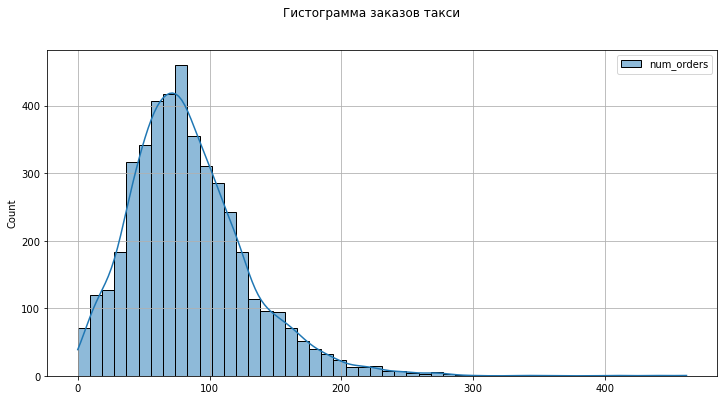

In [143]:
fig = plt.figure(figsize=(12, 6))
sns.histplot(data=taxi, kde=True, bins=50)
plt.suptitle(f"Гистограмма заказов такси")
plt.grid(True)
plt.show()

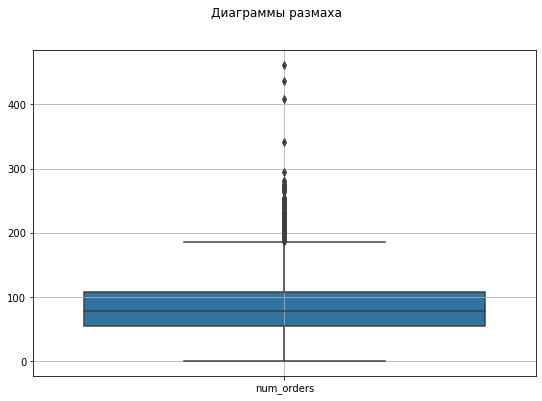

In [144]:
fig = plt.figure(figsize=(9, 6))
sns.boxplot(data=taxi)
plt.suptitle("Диаграммы размаха")
plt.grid(True)
plt.show()

Похоже на нормальное, сдвинуто влево, медиана чуть ниже ста. Пробежимся скользящим средним в неделю:

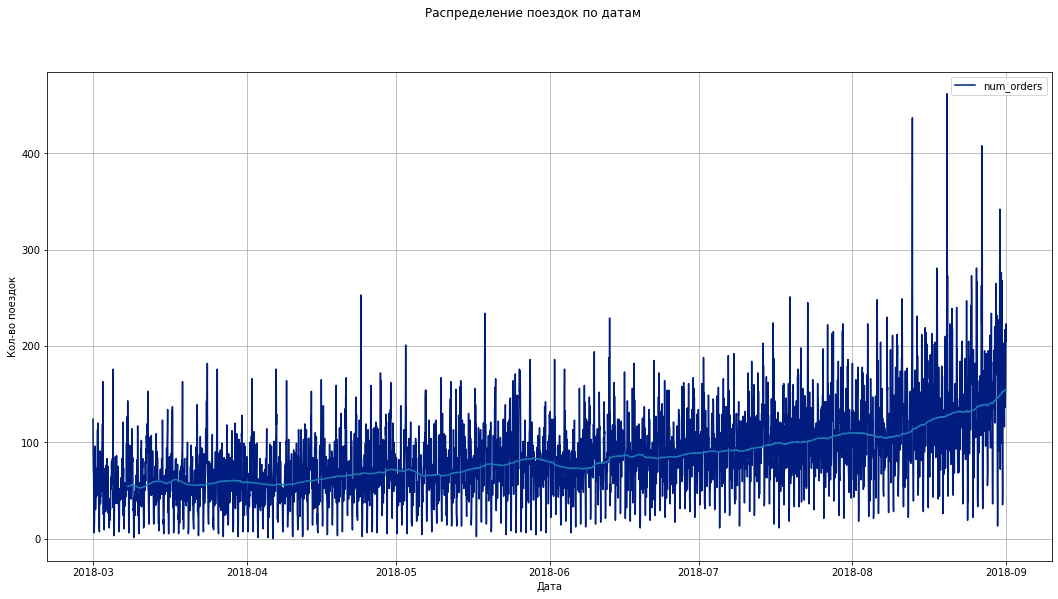

In [145]:
rolling = taxi.rolling(24*7).mean()

plt.figure(figsize=(18, 9))
sns.lineplot(data=taxi, palette="dark")
sns.lineplot(data=rolling, legend=False)
plt.xlabel('Дата')
plt.ylabel('Кол-во поездок')
plt.suptitle("Распределение поездок по датам")
plt.grid()

Видим тренд на увеличение числа поездок, для подтверждения декомпозируем наш временной ряд.

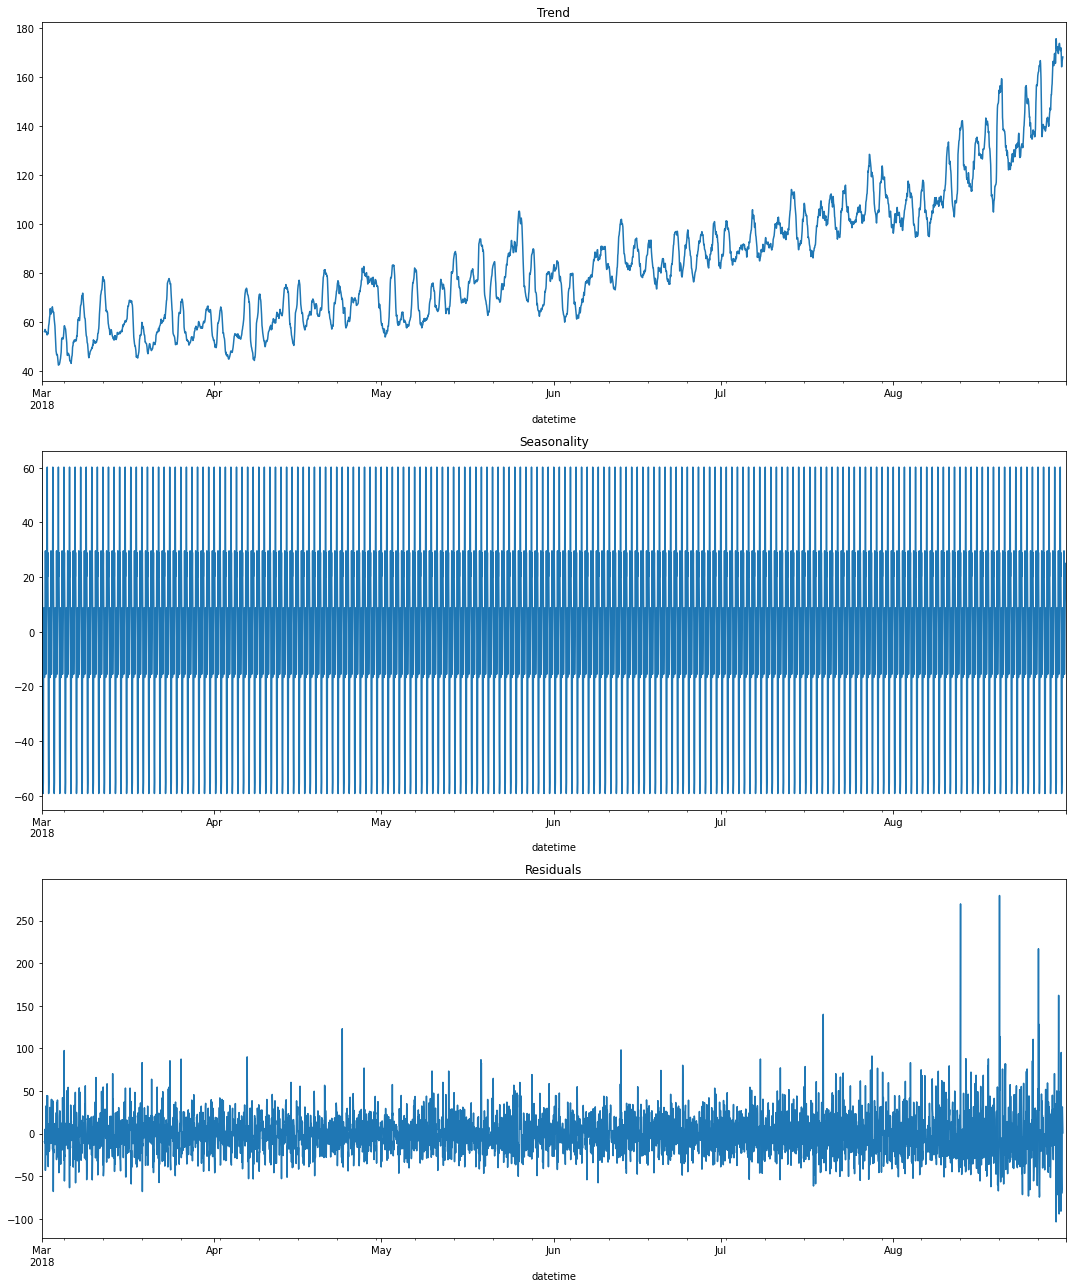

In [146]:
decomposed_taxi = seasonal_decompose(taxi)

plt.figure(figsize=(15, 18))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)
decomposed_taxi.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed_taxi.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed_taxi.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

<AxesSubplot:title={'center':'Сезонность заказов в течение одной из недель июля'}, xlabel='datetime'>

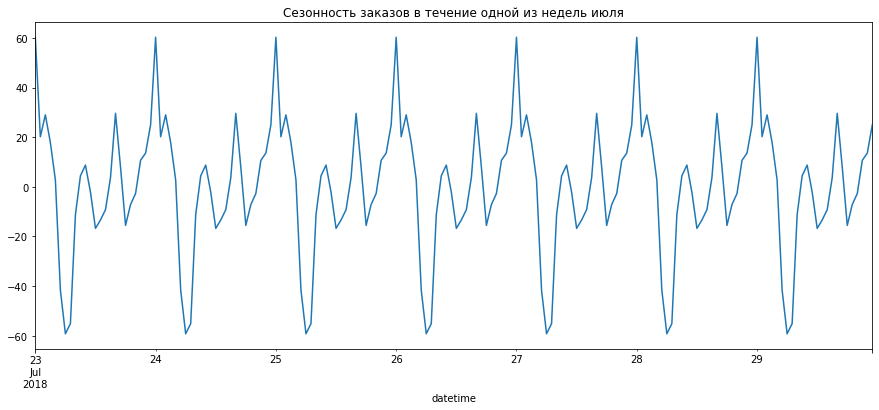

In [147]:
plt.figure(figsize=(15, 6))
plt.title("Сезонность заказов в течение одной из недель июля")
decomposed_taxi.seasonal['2018-07-23':'2018-07-29'].plot()

<AxesSubplot:title={'center':'Сезонность заказов в течение одной из недель июля'}, xlabel='datetime'>

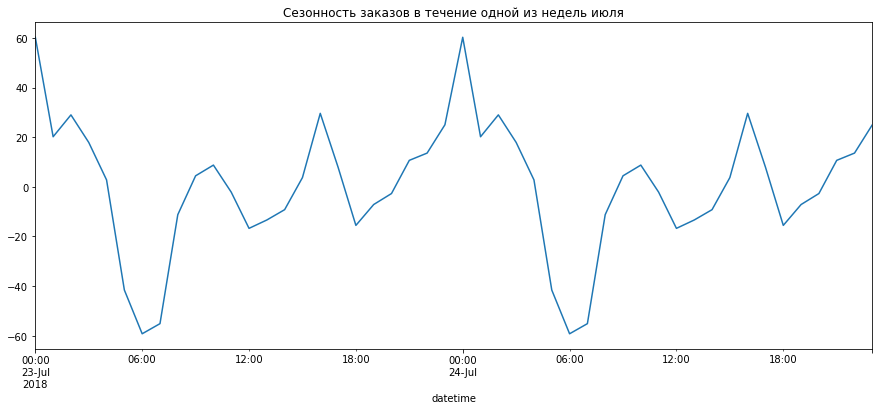

In [148]:
plt.figure(figsize=(15, 6))
plt.title("Сезонность заказов в течение одной из недель июля")
decomposed_taxi.seasonal['2018-07-23':'2018-07-24'].plot()

Сезонность по часам точно присутствует, надо будет это учитывать. Пики по полночам, неужели в аэропорту весь ажиотаж ночью? Или это связано с тем, что ближе к ночи есть проблемы с общественным транспортом? Интересно 

Посмотрим есть ли сезонность зависящая от дня недели?

In [149]:
decomposed_taxi_days = seasonal_decompose(taxi.resample('1D').sum())

<AxesSubplot:title={'center':'Сезонность заказов в течение 4 недель июля'}, xlabel='datetime'>

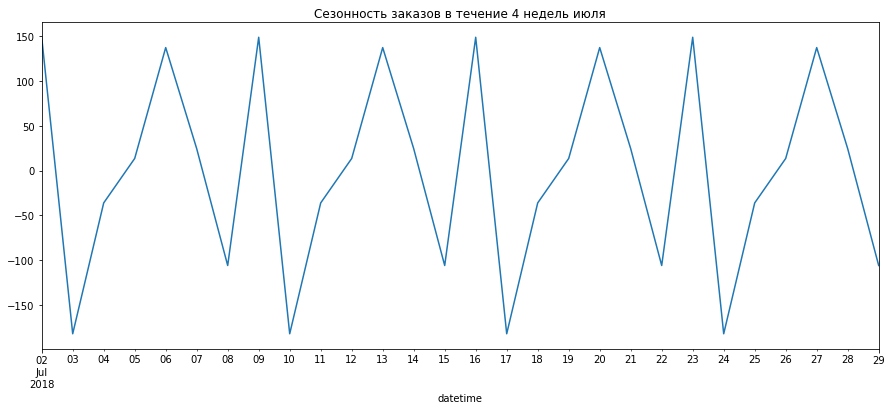

In [150]:
plt.figure(figsize=(15, 6))
plt.title("Сезонность заказов в течение 4 недель июля")
decomposed_taxi_days.seasonal['2018-07-02':'2018-07-29'].plot()

Понедельник и пятница - рекордсмены! Это командировочные? Это надо будет учитывать!

Проверим наш ряд на стационарность (теорию брал отсюда -https://habr.com/ru/post/207160/ и отсюда https://habr.com/ru/company/ods/blog/327242/)

In [151]:
test = adfuller(taxi)
print('adf: ', test[0]) 
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, ряд стационарен')

adf:  -3.068924289027941
p-value:  0.02894005140261409
Critical values:  {'1%': -3.431842162413052, '5%': -2.8621993540813637, '10%': -2.567120978470452}
единичных корней нет, ряд стационарен


### Вывод по анализу данных.

В данных обнаружен восходящий тренд, в среднем количество поездок увеличивается от начальных дат к конечным. Мы выделили сезонную (периодичную) закономерность в течние одних суток: максимально число поездок в полночь, минимальное - в 6 утра. И еще есть повторяющиеся экстремумы. Выделили недельную сезонность: поездок в понедельник и пятницу стабильно больше, чем в другие дни. Другие временные закономерности нельзя выделить в виду ограниченности данных, в таблице представлены данные с марта по август включительно. Всё это надо будет учесть в построении наших моделей, путём добавления новых значимых признаков в датафрейм.

По статистиечскому тесту Дик-Фуллера наш ряд может быть принят стационарным, значит дальнейших манипуляций перед построеним моделей производить с ним не нужно.

## Построение моделей

### Добавление признаков.

Порассуждаем, какие признаки нам могут дополнительно понадобиться:

 `Год` - не нужен, т.к. у нас год один, 2018.
 
 `Месяц` - хоть ряд у нас по критерию Дики — Фуллера стационарный, но у нас все равно прослеживается тренд к увеличению поездок. Я думаю месяц тут не нужен, я попробую добавить признак: количество дней со стартовой даты.
 
 `День` - сам номер дня в месяце нам тоже не нужен, тут гораздо важней день недели - смотри анализ. А увеличение порядкого дня как растущий общий тренд, будет виден из предыдущего пункта.
 
 `Часы` - нужны, так как есть явная сезонность по часам.
 
 `Отстающие значения` - lag features, нужны с их количеством поэксперементируем ниже.
 
 `Скользящее среднее` - лишним не будет, с его размером тоже поэксперементируем.

In [152]:
taxi['days_from_start'] = (taxi.index - taxi.index.min()).days
taxi['dayofweek'] = taxi.index.dayofweek
taxi['hour'] = taxi.index.hour

Тут еще вот что подумалось, что наверняка должно оказывать влияние на количество вызовов такси такой фактор: выходной у нас это день или обычный. Кроме субботы и воскресенья у нас еще есть куча праздников, а еще бывают рабочие субботы. Давайте взглянем на производственный календарь 2018 года

In [153]:
Image(url= "https://pbs.twimg.com/media/DS_JbGUW4AA8Ate.jpg")

Так я и думал: длинные праздники, рабочие субботы, дыры посреди недели.

In [154]:
#по онлайн-календарю:
holidays = [7, 8, 60, 61, 62, 69, 102, 103] #праздничные дни кроме суббот и воскресений по счёту с 1.03.2018
working_saturdays = [58, 100] #рабочие субботы по счёту с 1.03.2018

In [155]:
taxi['is_holiday'] = 0
taxi.loc[taxi.dayofweek.isin([5, 6]), 'is_holiday'] = 1
taxi.loc[taxi.days_from_start.isin(holidays), 'is_holiday'] = 1
taxi.loc[taxi.days_from_start.isin(working_saturdays), 'is_holiday'] = 0

In [156]:
display(taxi.head(3))
display(taxi.sample(3))
taxi.tail(3)

,num_orders,days_from_start,dayofweek,hour,is_holiday
datetime,,,,,
2018-03-01 00:00:00,124,0,3,0,0
2018-03-01 01:00:00,85,0,3,1,0
2018-03-01 02:00:00,71,0,3,2,0


,num_orders,days_from_start,dayofweek,hour,is_holiday
datetime,,,,,
2018-06-18 08:00:00,85,109,0,8,0
2018-07-15 19:00:00,87,136,6,19,1
2018-07-19 12:00:00,110,140,3,12,0


,num_orders,days_from_start,dayofweek,hour,is_holiday
datetime,,,,,
2018-08-31 21:00:00,159,183,4,21,0
2018-08-31 22:00:00,223,183,4,22,0
2018-08-31 23:00:00,205,183,4,23,0


Работает, остальные признаки будем добавлять функцией.

In [158]:
def make_features(data, max_lag, rolling_mean_size):
    modified_data = data.copy()
    for lag in range(1, max_lag + 1):
        modified_data['lag_' + str(lag)] = modified_data['num_orders'].shift(lag)
    modified_data['rolling_mean'] = modified_data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return modified_data

### Линейная регрессия

In [159]:
def predict_dataset(X, y, model):
    preds = model.predict(X)
    RMSE = mean_squared_error(y, preds, squared=False)
    return RMSE

Попробуем выбрать значения количества отстающих  и величины скользящей средней. На курсах ничего не говорили об их необходимой или желательной размерности, интуитивно понятно, что чем больше количество отстающих, тем, наверное, мы точнее должны предсказывать, но из-за этого мы можем раздуть базу и\или поудалять много первоначальных значений, т.к. сдвиги дают пропуски, от которых мы избавляемся дропом. В общем взял максимум 168 - это недельный цикл и прогнал в двух последовательных циклах. В итоговом цикле, чтоб ревьюеру не ждать, оставил только то, что дало лучшую итоговую метрику. (а у меня на компе считалось 168^2 раз.)

In [162]:
rmse_temp = 10000000
cv = TimeSeriesSplit(n_splits=3) 

for max_lag in range(168, 169): #гонял опять на всех, оставил лучшее
    for rolling_mean_size in range(31, 32):
        X = make_features(taxi, max_lag, rolling_mean_size)
        X.dropna(inplace=True)
        y = X.num_orders
        X.drop(['num_orders'], axis=1, inplace=True)
        X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.1)
        model = LinearRegression(normalize=True)
        rmse = -1 * cross_val_score(model, X, y, cv=cv, scoring = 'neg_root_mean_squared_error').mean()
        print(rmse)
        if rmse < rmse_temp:
            rmse_temp = rmse
            max_lag_best = max_lag
            rolling_mean_size_best = rolling_mean_size
print(f"Линейная регрессия. RMSE на обучающей: {rmse_temp}, при max_lag_best={max_lag_best} и rolling_mean_size_best={rolling_mean_size_best}")      

25.053462468737283
Линейная регрессия. RMSE на обучающей: 25.053462468737283, при max_lag_best=168 и rolling_mean_size_best=31


Посмотрим на тестовой:

In [163]:
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X, y, shuffle=False, test_size=0.1)
model_lr = LinearRegression(normalize=True)
model_lr.fit(X_train_lr, y_train_lr)
predict_dataset(X_test_lr, y_test_lr, model_lr)

34.752644974965406

Ух ты! Отличный результат. На 30% лучше требуемой метрики. Даже интересно посмотреть, что он там насчитал.

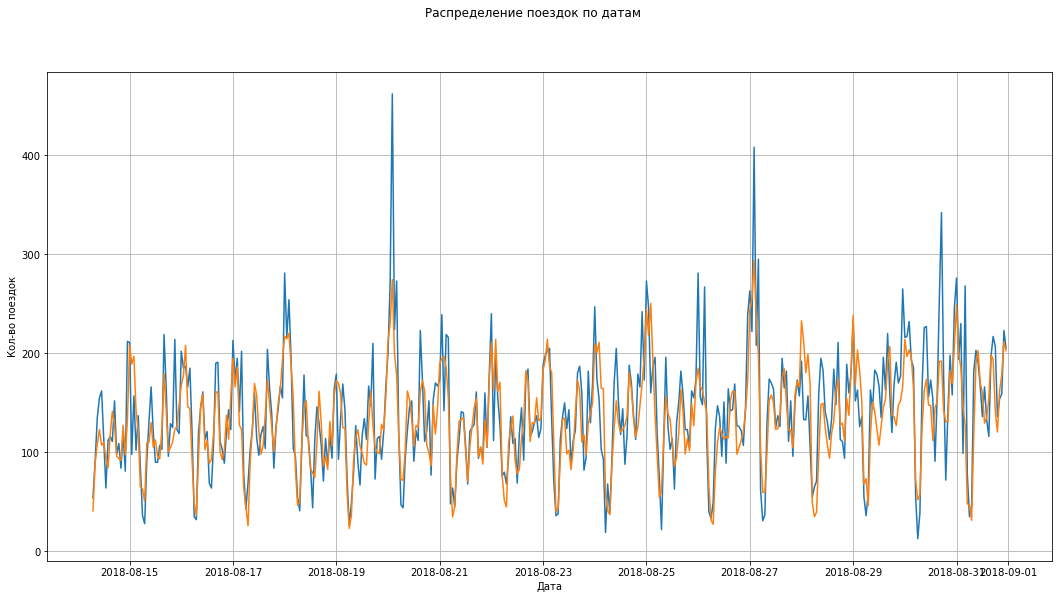

In [164]:
preds_lr = pd.Series(model_lr.predict(X_test), index=y_test.index)

plt.figure(figsize=(18, 9))
sns.lineplot(data=y_test, palette="dark")
sns.lineplot(data=preds_lr)
plt.xlabel('Дата')
plt.ylabel('Кол-во поездок')
plt.suptitle("Распределение поездок по датам")
plt.grid()

В основном не выловлены странные пики.

In [165]:
results = pd.DataFrame({'RMSE_train': [25.05], 'RMSE_test': [34.75]}, index=['linear_regression'])
display(results)

,RMSE_train,RMSE_test
linear_regression,25.05,34.75


### Случайный лес

In [166]:
RND_ST = 8169

In [167]:
max_lag = 168
rolling_mean_size = 109 #Для рандомного леса это получились лучшие цифры 
X = make_features(taxi, max_lag, rolling_mean_size)
X.dropna(inplace=True)
y = X.num_orders
X.drop(['num_orders'], axis=1, inplace=True)
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X, y, shuffle=False, test_size=0.1)

In [168]:
estimator = range(106, 107)
depth = range(15, 16)
split = range(6, 7)
min_samples_leaf = range(2, 3)
max_features = ['sqrt']
bootstrap = [False]

parameters = {'n_estimators': estimator,
              'max_depth': depth,
              'min_samples_split': split,
              'max_features': max_features,
              'min_samples_leaf': min_samples_leaf,
              'bootstrap': [bootstrap]}

In [169]:
cv = TimeSeriesSplit(n_splits=3) #попробуем кросс-валидацию для временных рядов

In [170]:
model_r = RandomForestRegressor(random_state=RND_ST)
random_search = RandomizedSearchCV(model_r, param_distributions = parameters, n_jobs=-1,
                                    scoring='neg_root_mean_squared_error', cv = cv,
                                    n_iter = 1, verbose = 0)
random_search.fit(X_train_r, y_train_r)
model_r_final = random_search.best_estimator_
print(f"Случайный лес. RMSE на обучающей: {-random_search.best_score_}")

Случайный лес. RMSE на обучающей: 25.225638410118705


In [171]:
predict_dataset(X_test_r, y_test_r, model_r_final)

39.92529449349502

In [172]:
results.loc['RandomForestRegreesor'] = [25.23, 39.93]
results.sort_values(by='RMSE_test')

,RMSE_train,RMSE_test
linear_regression,25.05,34.75
RandomForestRegreesor,25.23,39.93


### LGBMRegressor

In [173]:
max_lag = 168
rolling_mean_size = 116
X = make_features(taxi, max_lag, rolling_mean_size)
X.dropna(inplace=True)
y = X.num_orders
X.drop(['num_orders'], axis=1, inplace=True)
X_train_lgbm, X_test_lgbm, y_train_lgbm, y_test_lgbm = train_test_split(X, y, shuffle=False, test_size=0.1)

In [174]:
n_estimators = range(150, 151)
max_depth = range(23, 24)
learning_rate = np.arange(0.11, 0.12, 0.01)
num_leaves = range(44, 45)


parameters = {"learning_rate": learning_rate,
              "max_depth": max_depth,
              "num_leaves": num_leaves,
              "n_estimators": n_estimators}

In [175]:
model_lgbm = LGBMRegressor(random_state=RND_ST, verbose=-1)
random_search = RandomizedSearchCV(model_lgbm, param_distributions=parameters, n_jobs=-1,
                                   scoring='neg_root_mean_squared_error', cv=cv,
                                   n_iter=1, verbose=0)  # без рандом_стейта, чтоб прогонял всешда по разным выборкам
random_search.fit(X_train_lgbm, y_train_lgbm)
model_lgbm_final = random_search.best_estimator_
print(f"LGBM-регрессор. RMSE на обучающей: {-random_search.best_score_}")

LGBM-регрессор. RMSE на обучающей: 24.23527339811803


In [176]:
predict_dataset(X_test_lgbm, y_test_lgbm, model_lgbm_final)

36.456894778188456

In [177]:
results.loc['LGBMRegressor'] = [24.24, 36.46]
results.sort_values(by='RMSE_test')

,RMSE_train,RMSE_test
linear_regression,25.05,34.75
LGBMRegressor,24.24,36.46
RandomForestRegreesor,25.23,39.93


Лучше, чем у случайного леса, но не так хорошо как у линейной регрессии.

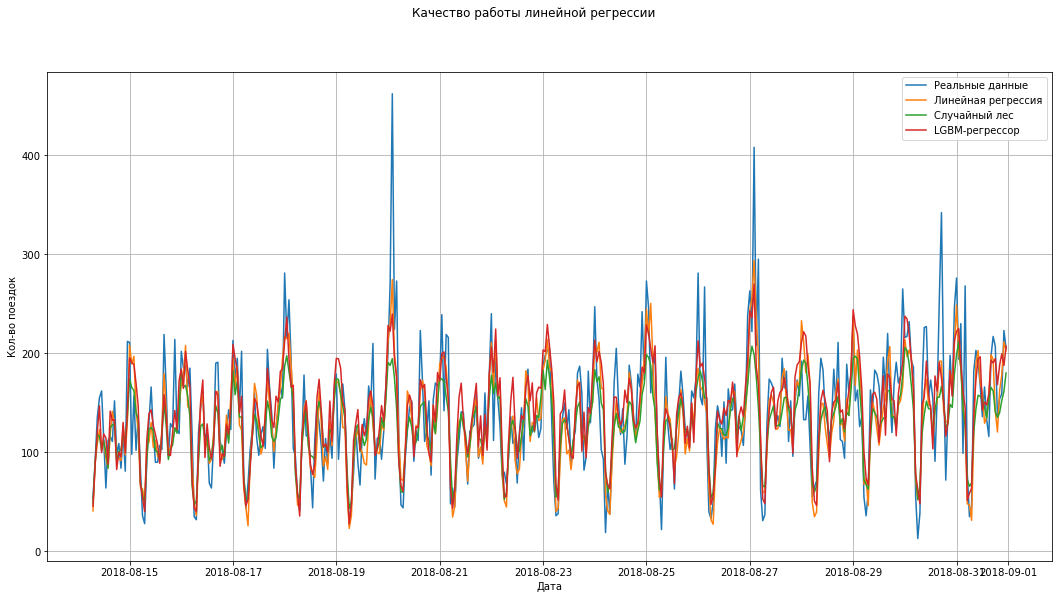

In [178]:
#for model in [model_lr, model_r_final,model_lgbm_final]
preds_lr = pd.Series(model_lr.predict(X_test_lr), index=y_test_lr.index)
preds_r = pd.Series(model_r_final.predict(X_test_r), index=y_test_r.index)
preds_lgbm = pd.Series(model_lgbm_final.predict(X_test_lgbm), index=y_test_lgbm.index)
plt.figure(figsize=(18, 9))
sns.lineplot(data=y_test_lr, legend="auto")
sns.lineplot(data=preds_lr, legend="auto")
sns.lineplot(data=preds_r, legend="auto")
sns.lineplot(data=preds_lgbm, legend="auto")
plt.xlabel('Дата')
plt.ylabel('Кол-во поездок')
plt.suptitle("Качество работы линейной регрессии")
plt.legend(['Реальные данные', 'Линейная регрессия', 'Случайный лес', 'LGBM-регрессор' ])
plt.grid()

## Общий вывод

В представленных нам данных содержались исторические данные о заказах такси в аэропортах.

Необходимо было построить модель для предсказания количество заказов такси на следующий час со значением метрики RMSE на тестовой выборке не больше 48.

Данные поступили в хорошем качестве. По результатам проведенного анализа, было выявлено несколько свойств данного временного ряда: тренд, сезонности, которые были учтены в конструировании признаков перед построением моделей.

По результатам построения моделей, лучшую метрику дала модель LinearRegressor, значение RMSE = 34.72, что на 30% лучше, чем установленный заказчиком порог. 

✽✾✿❁❃❋❀